In [1]:
# Import Dependencies

In [1]:
import pandas as pd
import plotly.express as px
import math
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import Dict, List

In [ ]:
# Bring in the data

In [2]:
TRAIN_PATH = '../data/raw/train2.tsv'
VAL_PATH = '../data/raw/val2.tsv'
TEST_PATH = '../data/raw/test2.tsv'

In [3]:
train_df = pd.read_csv(TRAIN_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])
val_df = pd.read_csv(VAL_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])
test_df = pd.read_csv(TEST_PATH, sep="\t", names=["id", "statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"])

In [4]:
# Display at most 500 columns/rows
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 500

In [7]:
# Basic Statistics

In [8]:
len(train_df)

10242

In [9]:
len(val_df)

1284

In [10]:
len(test_df)

1267

In [12]:
train_df.columns

Index(['id', 'statement_json', 'label', 'statement', 'subject', 'speaker',
       'speaker_title', 'state_info', 'party_affiliation', 'barely_true_count',
       'false_count', 'half_true_count', 'mostly_true_count',
       'pants_fire_count', 'context', 'justification'],
      dtype='object')

In [13]:
train_df.head()

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification
0,0.0,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"That's a premise that he fails to back up. Annie's List makes no bones about being comfortable with candidates who oppose further restrictions on late-term abortions. Then again, this year its backing two House candidates who voted for more limits."
1,1.0,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started when natural gas took off That started to begin in President (George W. ) Bushs administration. ""No doubt, natural gas has been gaining ground on coal in generating electricity. The trend started in the 1990s but clearly gained speed during the Bush administration when the production of natural gas -- a competitor of coal -- picked up. But analysts give little credit or blame to Bush for that trend. They note that other factors, such as technologic..."
2,2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"Obama said he would have voted against the amendment if he had been present. So though Clinton may have ""agreed"" with McCain on the issue, they did not technically vote the same way on it. To say that voting for Kyl-Lieberman is ""giving George Bush the benefit of the doubt on Iran"" remains a contentious issue. But Obama's main point is that Clinton and McCain were on the same side, and that is correct."
3,3.0,1123.json,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"The release may have a point that Mikulskis comment could open the door to ""medically necessary"" coverage which conceivably may include sex-change operations. But it's unclear whether her amendment will remain in the legislation, and there's nothing specific in the legislation on sex-change procedures and nothing else solid that indicates such coverage will be provided. The news release cherry-picked a few fleeting references to gender and sexual orientation in completely unrelated contexts ..."
4,4.0,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround started at the end of my term. ""During Crists last year in office, Floridas economy experienced notable gains in personal income and industrial production, and more marginal improvements in the unemployment rate and in payroll employment. But GDP didnt grow again until Scott took office. Economists say Crist deserves some credit for the economic turnaround because he accepted federal stimulus dollars, but they add that any state is inevitably buffeted..."


In [5]:
train_df.dropna(subset=['label'], inplace=True)
len(train_df)

10240

In [6]:
# Normalized distribution of labels (roughly equal except for the flagrantly false statement "pants-fire")
train_df.label.value_counts(normalize=True)

half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: label, dtype: float64

In [7]:
label_ratios = train_df.label.value_counts(normalize=True)
px.bar(label_ratios, x=label_ratios.index, y=label_ratios.values, labels={"index": "label", "y": "ratios"}, title="Label Distribution")

In [8]:
# Notice a huge number of speaker titles
train_df.speaker_title.nunique()

1184

In [9]:
train_df.speaker_title[train_df.speaker_title.notnull()]

0                                 State representative
1                                       State delegate
2                                            President
5                           Wisconsin Assembly speaker
7                                            President
                             ...                      
10230                                  President-Elect
10232                                          Senator
10233                      State Senator, 8th District
10234                      Senior editor, The Atlantic
10241    chairman of the Republican National Committee
Name: speaker_title, Length: 7343, dtype: object

In [19]:
# A lot of repetition in speaker_title - not canonicalized
train_df.speaker_title.value_counts()[:20]

President                        492
U.S. Senator                     479
Governor                         391
President-Elect                  273
U.S. senator                     263
Presidential candidate           254
Former governor                  176
U.S. Representative              172
Milwaukee County Executive       149
Senator                          147
State Senator                    108
U.S. representative              103
U.S. House of Representatives    102
Attorney                          81
Congressman                       80
Social media posting              78
Governor of New Jersey            78
Co-host on CNN's "Crossfire"      73
State Representative              72
State representative              66
Name: speaker_title, dtype: int64

In [20]:
train_df.speaker.value_counts()

barack-obama                                   488
donald-trump                                   273
hillary-clinton                                239
mitt-romney                                    176
scott-walker                                   149
                                              ... 
lorraine-fende                                   1
nfederation-o-independent-business-virginia      1
jim-moore                                        1
scott-surovell                                   1
alan-powell                                      1
Name: speaker, Length: 2910, dtype: int64

In [21]:
train_df.speaker.nunique()

2910

In [10]:
affiliation_counts = train_df.party_affiliation.value_counts()
px.bar(affiliation_counts, x=affiliation_counts.index, y=affiliation_counts.values, labels={"index": "affiliation", "y": "counts"}, title="Counts Per Affiliation")

In [11]:
# Convert from 6-way scale to binary scale
def get_binary_label(label: str) -> bool:
    if label in {'pants-fire', 'barely-true', 'false'}:
        return False
    elif label in {'true', 'half-true', 'motly-true'}:
        return True

In [12]:
train_df['binary_label'] = train_df.label.apply(get_binary_label)

In [13]:
party_groups = train_df.groupby(["party_affiliation"])

In [14]:
party_groups.get_group("republican").binary_label.value_counts(normalize=True)

False    0.591029
True     0.408971
Name: binary_label, dtype: float64

In [15]:
party_groups.get_group("democrat").binary_label.value_counts(normalize=True)

True     0.555424
False    0.444576
Name: binary_label, dtype: float64

In [16]:
train_df.binary_label.value_counts(normalize=True)

False    0.54216
True     0.45784
Name: binary_label, dtype: float64

In [17]:
unigram_lens = train_df.statement.str.split().str.len()

In [18]:
px.histogram(unigram_lens, x=unigram_lens.values, labels={"x": "unigram lens"}, title="Unigram Length Distribution")

In [19]:
unigram_lens.median()

17.0

In [20]:

unigram_lens.mean()

18.030859375

In [35]:

unigram_lens.max()

479

In [21]:
# Ran into some noisy labels for certain columns so have to remove it
train_df[train_df.pants_fire_count == "a television interview"]

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label


In [22]:
# Drop column with invalid type for `pants_fire`
train_df.drop(6134, inplace=True)

In [23]:

# Separate true samples from false ones
true_ex = train_df[train_df.binary_label == True]
false_ex = train_df[train_df.binary_label == False]

In [24]:
train_df.barely_true_count.describe()

count    10237.00000
mean        11.53082
std         18.97315
min          0.00000
25%          0.00000
50%          2.00000
75%         12.00000
max         70.00000
Name: barely_true_count, dtype: float64

In [40]:
# TODO (mihail): Include feature for credit history counts (binned)
barely_true_counts = train_df.barely_true_count.value_counts().sort_index()
px.bar(barely_true_counts, x=barely_true_counts.index, y=barely_true_counts.values, labels={"index": "credit", "y": "counts"}, title="Barely True Credit Distribution")


In [25]:
px.histogram(train_df, x="barely_true_count", labels={"x": "credit score"}, title="Barely True Credit Histogram", nbins=10)

In [26]:
barely_true_counts.values

NameError: name 'barely_true_counts' is not defined

In [44]:
train_df.false_count.describe()

count    10237.000000
mean        13.284556
std         24.113327
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        114.000000
Name: false_count, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10239 entries, 0 to 10241
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10239 non-null  float64
 1   statement_json     10239 non-null  object 
 2   label              10239 non-null  object 
 3   statement          10239 non-null  object 
 4   subject            10237 non-null  object 
 5   speaker            10237 non-null  object 
 6   speaker_title      7342 non-null   object 
 7   state_info         8031 non-null   object 
 8   party_affiliation  10237 non-null  object 
 9   barely_true_count  10237 non-null  float64
 10  false_count        10237 non-null  float64
 11  half_true_count    10237 non-null  float64
 12  mostly_true_count  10237 non-null  float64
 13  pants_fire_count   10237 non-null  float64
 14  context            10137 non-null  object 
 15  justification      10153 non-null  object 
 16  binary_label       827

In [46]:
train_df.half_true_count.describe()

count    10237.000000
mean        17.133926
std         35.848256
min          0.000000
25%          0.000000
50%          3.000000
75%         13.000000
max        160.000000
Name: half_true_count, dtype: float64

In [47]:

train_df.mostly_true_count.describe()

count    10237.000000
mean        16.434014
std         36.153445
min          0.000000
25%          0.000000
50%          3.000000
75%         11.000000
max        163.000000
Name: mostly_true_count, dtype: float64

In [48]:

train_df.pants_fire_count.describe()

count    10237.000000
mean         6.201231
std         16.129705
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [49]:

train_df.pants_fire_count.astype(float).describe()

count    10237.000000
mean         6.201231
std         16.129705
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

In [50]:
true_ex.statement.str.split().str.len().describe()

count    3789.000000
mean       18.454473
std         8.651553
min         2.000000
25%        13.000000
50%        17.000000
75%        23.000000
max       242.000000
Name: statement, dtype: float64

In [51]:

false_ex.statement.str.split().str.len().describe()

count    4488.000000
mean       17.488191
std         9.371839
min         2.000000
25%        12.000000
50%        16.000000
75%        22.000000
max       317.000000
Name: statement, dtype: float64

In [27]:

# Sample true and false examples to observe characteristics
true_ex.sample(frac=0.2).head(5)

,id,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
3856,3868.0,1204.json,true,FDR was called a socialist and a communist.,history,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"interview on ""Late Night with David Letterman""","Further, criminals will never submit to such a system so it will never truly be universal. "" Our rating Taylor said polling shows that nearly 74 percent of National Rifle Association members ""support requiring background checks for all gun sales. ""The most recent national poll of NRA members that we could find, done in January 2013 by Johns Hopkins University, found that 73. 7 percent of the members supported requiring background checks for all gun sales. Update:After this item was published...",True
8697,8725.0,770.json,half-true,"As mayor, every year I was in office I did reduce taxes.",taxes,sarah-palin,NaN,Alaska,republican,9.0,19.0,9.0,6.0,6.0,a debate in St. Louis,"When Romney spoke about setting timetables for troop withdrawal it was within the context of meeting benchmarks or goals for progress there. For that reason, we come down on the more negative side of the Truth-O-Meter's dial.",True
8076,8104.0,9056.json,half-true,"Were at the point of reaching 2 million deportations ...this is a historic level, more than any other president of the United States.","corrections-and-updates,homeland-security,immigration",janet-murguia,National Council of La Raza president,"Washington, D.C.",activist,0.0,0.0,1.0,0.0,0.0,an interview on Univision's 'Al Punto',"At a recent rally in Willingboro, Lewis accused Allen of receiving taxpayer-funded health care, while taking health care away from the public. Allen receives state health benefits, and she must contribute toward her premium costs. The governor eliminated the funding for family planning services and a yes-vote from Allen wouldnt have changed that. Also, the funding cut has affected a fraction of her constituents and similar services are being offered at other health centers.",True
4003,4015.0,13092.json,true,"In the mid 1990s, in our state, (Florida was) No. 1 in violent crime in America. ... The only concern I had was for the citizens of Florida, who were subjected to a violent crime every three minutes and 45 seconds.",crime,charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,a debate,"Allen said that, as governor, he stopped soaring tuition costs by implementing a tuition freeze. Allen and the General Assembly did impose a freeze after tuition had risen sharply during the early 1990s recession. Allen had leeway to cap tuitions because a healthy economy during his term allowed lawmakers to increase state appropriations to colleges and universities.",True
8961,8989.0,642.json,true,"Says McCain once said that on ""the most important issues of our day, I've been totally in agreement and support of President Bush.""",bush-administration,joe-biden,U.S. senator,Delaware,democrat,11.0,10.0,21.0,16.0,4.0,"a speech in Springfield, Ill.","All in all, it would require a break from political reality to ding the senator for accepting contributions from interest groups wielding clout at the Capitol. Besides, we see no sign Birdwell ever vowed not to take such aid. Still, after poking his opponent for piling up lobby money, Birdwell is evidently aboard with doing the same.",True


In [28]:

stripped = false_ex.state_info.copy().str.strip()
false_ex.loc[:, "state_info"] = stripped

stripped = true_ex.state_info.copy().str.strip()
true_ex.loc[:, "state_info"] = stripped

In [29]:
# Clean up the variants of state info 
CANONICAL_TO_VARIANTS = {
    "Tennessee": {"Tennessee", "Tennesse"},
    "Washington D.C.": {"District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"},
    "Texas": {"Tex", "Texas"}, 
    "Washington": {"Washington", "Washington state"},
    "Virginia": {"Virginia", "Virgina", "Virgiia"},
    "Pennsylvania": {"Pennsylvania", "PA - Pennsylvania"},
    "Rhode Island": {"Rhode Island", "Rhode island"},
    "Ohio": {"Ohio", "ohio"}
}

def get_variant_to_canonical(can_to_var: Dict):
    variant_to_canonical = {}
    for canonical, variant in can_to_var.items():
        for var in variant:
            variant_to_canonical[var] = canonical
    return variant_to_canonical

variant_to_canonical = get_variant_to_canonical(CANONICAL_TO_VARIANTS)

In [30]:

def clean_variant(state_info, variant_to_canonical):
    if state_info in variant_to_canonical.keys():
        return variant_to_canonical[state_info]
    return state_info

true_ex.loc[:, "state_info"] = true_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))
false_ex.loc[:, "state_info"] = false_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))

In [32]:
# State Info Distribution
# Takeaway from below seems to be that no state is considerably more inclined to "True" or "False" statements (top in each category are roughly the same)

In [33]:
state_true_counts = true_ex.state_info.value_counts()
px.bar(state_true_counts, x=state_true_counts.index, y=state_true_counts.values, labels={"index": "state", "y": "counts"}, title="True Statement State Distribution")

In [34]:
state_false_counts = false_ex.state_info.value_counts()
px.bar(state_false_counts, x=state_false_counts.index, y=state_false_counts.values, labels={"index": "state", "y": "counts"}, title="False Statement State Distribution")

In [35]:
def get_top_ngrams(corpus, ngram_len: int=1, num: int=None) -> List:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num]

In [36]:
# Ture Unigrams

In [37]:
top_unigrams_true = get_top_ngrams(true_ex.statement, 1, 30)
top_unigrams_true

[('says', 813),
 ('percent', 532),
 ('state', 341),
 ('000', 286),
 ('years', 253),
 ('year', 247),
 ('obama', 241),
 ('tax', 235),
 ('states', 228),
 ('million', 216),
 ('health', 213),
 ('jobs', 205),
 ('president', 203),
 ('people', 198),
 ('new', 171),
 ('texas', 164),
 ('care', 158),
 ('taxes', 154),
 ('billion', 152),
 ('federal', 139),
 ('country', 139),
 ('said', 130),
 ('united', 126),
 ('time', 121),
 ('rate', 120),
 ('pay', 119),
 ('voted', 117),
 ('government', 115),
 ('american', 113),
 ('law', 113)]

In [38]:
true_state_distr = pd.DataFrame(top_unigrams_true, columns=["unigram", "count"])

In [39]:

px.bar(true_state_distr, x="unigram", y="count", title="Top True Unigrams Frequency")

In [40]:
# False Unigrams

In [41]:
top_unigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), num=30)
false_state_distr = pd.DataFrame(top_unigrams_false, columns=["unigram", "count"])
px.bar(false_state_distr, x="unigram", y="count", title="Top False Unigrams Frequency")

In [42]:
# False Bigrams

In [43]:

top_bigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
false_state_distr = pd.DataFrame(top_bigrams_false, columns=["bigram", "count"])
px.bar(false_state_distr, x="bigram", y="count", title="Top False Bigrams Frequency")

In [44]:
# True Bigrams

In [45]:
top_bigrams_true = get_top_ngrams(true_ex[true_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
true_state_distr = pd.DataFrame(top_bigrams_true, columns=["bigram", "count"])
px.bar(true_state_distr, x="bigram", y="count", title="Top True Bigrams Frequency")

In [48]:
# Distribution of True vs. False Unigram Lens
# - true examples are slightly longer
# - bucketize length

In [49]:
true_ex.statement.str.split().str.len().describe()

count    3789.000000
mean       18.454473
std         8.651553
min         2.000000
25%        13.000000
50%        17.000000
75%        23.000000
max       242.000000
Name: statement, dtype: float64

In [50]:
false_ex.statement.str.split().str.len().describe()

count    4488.000000
mean       17.488191
std         9.371839
min         2.000000
25%        12.000000
50%        16.000000
75%        22.000000
max       317.000000
Name: statement, dtype: float64

In [51]:
train_df.statement.str.split().str.len().describe()

count    10239.000000
mean        18.031741
std          9.926004
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max        479.000000
Name: statement, dtype: float64

In [54]:
# Topic Modeling
# - Using latent semantic analysis which performs a singular value decomposition on a document-term matrix

## Analysis
# In true statements:
# Topic 2 deals with healthcare
# Topic 3 deals with jobs
# Topic 4 deals with taxes

# Limitations of LSA
# can't capture polysemy
# difficult to interpret
# bag of words representation are limited

In [55]:
def print_topics(model: TruncatedSVD, vectorizer: TfidfVectorizer, top_n: int=10) -> None:
    for idx, topic in enumerate(model.components_):
        print("Topic %d: " % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        print("\n")
        
def run_lsa_and_print_topics(df: pd.DataFrame, num_topics: int=5, num_words: int=5) -> None:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    lsa_model = TruncatedSVD(n_components=num_topics)
    tfidf_transformed = tfidf_vectorizer.fit_transform(df.statement)
    lsa_transform = lsa_model.fit_transform(tfidf_transformed)
    print_topics(lsa_model, tfidf_vectorizer)

In [56]:
run_lsa_and_print_topics(true_ex)

Topic 0: 
[('percent', 0.34016044400256534), ('says', 0.30311907561082474), ('state', 0.17673924089851406), ('health', 0.17306201355566048), ('obama', 0.1703333761278345), ('000', 0.16661872338340494), ('jobs', 0.1587588883041916), ('tax', 0.158075649422405), ('years', 0.1492225950245549), ('million', 0.14723280384869264)]


Topic 1: 
[('health', 0.45485725040644265), ('care', 0.38145461884691473), ('obama', 0.17062012808479443), ('barack', 0.14015895780406867), ('president', 0.13918854566547204), ('insurance', 0.1330814483997979), ('plan', 0.12468315742045391), ('says', 0.10538982751344984), ('million', 0.10525120935334281), ('reform', 0.07097615932117174)]


Topic 2: 
[('health', 0.48781173306763326), ('care', 0.40962139366175543), ('percent', 0.397251395758623), ('insurance', 0.14970666123999482), ('plan', 0.06960032527506799), ('income', 0.06278569802524714), ('reform', 0.05611142474428626), ('americans', 0.05479241769483297), ('pay', 0.051857954546106165), ('affordable', 0.0439962

In [57]:
run_lsa_and_print_topics(false_ex)

Topic 0: 
[('says', 0.3714632473152056), ('health', 0.25866520030414775), ('obama', 0.24443196273897277), ('care', 0.23837620857132064), ('president', 0.2043825260804359), ('percent', 0.18162791599923025), ('barack', 0.18107176160768618), ('tax', 0.1808331244682381), ('state', 0.1535499477997311), ('000', 0.13399289019986568)]


Topic 1: 
[('health', 0.5354874919580997), ('care', 0.5090740359863348), ('law', 0.16082582112987884), ('insurance', 0.11850433639160081), ('government', 0.09756005930215789), ('reform', 0.07639197137173225), ('plan', 0.057232323244846034), ('affordable', 0.05228752340878972), ('takeover', 0.05032165294380642), ('federal', 0.04911663140612192)]


Topic 2: 
[('obama', 0.42812490305847434), ('barack', 0.3622372017469398), ('president', 0.357975042153001), ('health', 0.2521603616697069), ('care', 0.23947054361124895), ('obamas', 0.07417094874750871), ('law', 0.06533709011117193), ('muslim', 0.04774837463243075), ('insurance', 0.0398001791947647), ('government', 0.

In [58]:
run_lsa_and_print_topics(true_ex, num_topics=10, num_words=8)

Topic 0: 
[('percent', 0.3401899998008806), ('says', 0.3031279526679949), ('state', 0.17666393573094977), ('health', 0.17306123829270406), ('obama', 0.1703192933891142), ('000', 0.16676604791476338), ('jobs', 0.15862321082055372), ('tax', 0.15806300188681438), ('years', 0.14920359247277976), ('million', 0.14741417027751189)]


Topic 1: 
[('health', 0.45237525569126225), ('care', 0.3816629538450884), ('obama', 0.17216061372285874), ('barack', 0.14191565101127332), ('president', 0.1400704249441105), ('insurance', 0.12946126889863246), ('plan', 0.12617756989380038), ('says', 0.10722303174152252), ('million', 0.10689869918189328), ('reform', 0.07115929921494067)]


Topic 2: 
[('health', 0.48725569621168), ('care', 0.4031840082944334), ('percent', 0.39303972998194997), ('insurance', 0.15572038145413514), ('plan', 0.06606308196240657), ('income', 0.06061565333145395), ('americans', 0.06002144168485092), ('reform', 0.05562516941714698), ('pay', 0.05228040140312225), ('10', 0.04609095155841335

In [59]:
run_lsa_and_print_topics(false_ex, num_topics=10, num_words=8)

Topic 0: 
[('says', 0.3716375681147466), ('health', 0.25863673718138463), ('obama', 0.24440637905513743), ('care', 0.2383507875943522), ('president', 0.20440226164488284), ('percent', 0.18172980483470738), ('barack', 0.18104595771743395), ('tax', 0.18079244630773383), ('state', 0.15347649077058134), ('000', 0.13405850438995232)]


Topic 1: 
[('health', 0.5353597061816739), ('care', 0.5091392831814322), ('law', 0.16149319482364424), ('insurance', 0.1183930735997054), ('government', 0.0936859874837931), ('reform', 0.07658826743868083), ('plan', 0.05787300274138809), ('affordable', 0.0527458567501397), ('takeover', 0.0496962880753743), ('federal', 0.04904360036915609)]


Topic 2: 
[('obama', 0.4304858574520517), ('barack', 0.36269076549200074), ('president', 0.3585193871772396), ('health', 0.2526460552759888), ('care', 0.24022200709387456), ('obamas', 0.07342845736117438), ('law', 0.06498162801136793), ('muslim', 0.048351554661507305), ('insurance', 0.03986621979084944), ('government', 0.

In [ ]:
# Sentiment Analysis
# Utilizing Vader sentiment analysis: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
# Not too much of a difference between true and false statements
# Perhaps a bit in the compound metric

In [60]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [61]:

analyzer = SentimentIntensityAnalyzer()

In [62]:

def extract_compound_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["compound"]

def extract_pos_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["pos"]

def extract_neg_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neg"]

def extract_neu_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neu"]

In [63]:
true_compound = true_ex.statement.apply(lambda x: extract_compound_sentiment(x))

In [64]:
px.histogram(true_compound, x=true_compound.values, labels={"x": "polarity"}, title="True Compound Polarity")

In [65]:

true_compound.describe()

count    3789.000000
mean       -0.016423
std         0.396988
min        -0.974400
25%        -0.296000
50%         0.000000
75%         0.273200
max         0.942300
Name: statement, dtype: float64

In [66]:

true_pos = true_ex.statement.apply(lambda x: extract_pos_sentiment(x))

In [67]:

true_neg = true_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [68]:

false_compound = false_ex.statement.apply(lambda x: extract_compound_sentiment(x))
false_pos = false_ex.statement.apply(lambda x: extract_pos_sentiment(x))
false_neg = false_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [69]:
px.histogram(false_compound, x=false_compound.values, labels={"x": "polarity"}, title="False Compound Polarity")

In [70]:

false_compound.describe()

count    4488.000000
mean       -0.002308
std         0.382506
min        -0.973500
25%        -0.273200
50%         0.000000
75%         0.273200
max         0.937100
Name: statement, dtype: float64

In [71]:
true_pos.describe()

count    3789.000000
mean        0.067601
std         0.095594
min         0.000000
25%         0.000000
50%         0.000000
75%         0.126000
max         0.560000
Name: statement, dtype: float64

In [72]:
false_pos.describe()

count    4488.000000
mean        0.073778
std         0.102164
min         0.000000
25%         0.000000
50%         0.000000
75%         0.138000
max         0.672000
Name: statement, dtype: float64

In [73]:

true_neg.describe()

count    3789.000000
mean        0.075867
std         0.111321
min         0.000000
25%         0.000000
50%         0.000000
75%         0.136000
max         0.796000
Name: statement, dtype: float64

In [74]:

false_neg.describe()

count    4488.000000
mean        0.074085
std         0.110037
min         0.000000
25%         0.000000
50%         0.000000
75%         0.138000
max         0.783000
Name: statement, dtype: float64

In [75]:

train_df.speaker_title.value_counts()

President                                        492
U.S. Senator                                     479
Governor                                         391
President-Elect                                  273
U.S. senator                                     263
                                                ... 
Pundit and communications consultant               1
Harrisonburg city councilman                       1
Theme park company                                 1
Executive director, NARAL Pro-Choice Virginia      1
President, The Whitman Strategy Group              1
Name: speaker_title, Length: 1184, dtype: int64

In [76]:
train_df.speaker_title.nunique()

1184

In [77]:

lower_speaker_title = train_df.speaker_title.dropna().astype(str).apply(lambda val: val.lower().strip().replace("-", " "))

<AxesSubplot:ylabel='Frequency'>

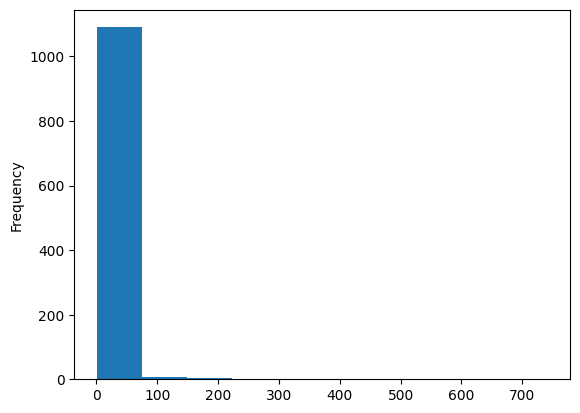

In [78]:

lower_speaker_title.value_counts().plot.hist()

In [79]:

lower_speaker_title.dropna(inplace=True)

In [80]:
lower_speaker_title

0                                 state representative
1                                       state delegate
2                                            president
5                           wisconsin assembly speaker
7                                            president
                             ...                      
10230                                  president elect
10232                                          senator
10233                      state senator, 8th district
10234                      senior editor, the atlantic
10241    chairman of the republican national committee
Name: speaker_title, Length: 7342, dtype: object

In [81]:

import editdistance

In [82]:

unique_speaker_title = lower_speaker_title.unique()

In [83]:
for i in range(0, len(unique_speaker_title)):
    for j in range(i, len(unique_speaker_title)):
        if i!=j and editdistance.eval(unique_speaker_title[i].strip(), unique_speaker_title[j].strip()) <= 2:
            print(i, j, unique_speaker_title[i], ", ",  unique_speaker_title[j])

7 1002 u.s. house member    4th district ,  u.s. house member    7th district
7 1003 u.s. house member    4th district ,  u.s. house member    6th district
7 1024 u.s. house member    4th district ,  u.s. house member    8th district
12 65 house minority leader ,  house majority leader
16 474 state senator ,  state senators
17 19 u.s. house of representative ,  u.s. house of representatives
19 780 u.s. house of representatives ,  n.c. house of representatives
31 1032 talk show host ,  talks show host
39 306 u.s. congressman ,  u. s. congressman
44 935 senate minority leader ,  senate majority leader
46 104 congressman ,  congresswoman
49 358 u.s. representative ,  u.s. representativej
50 464 state assembly member, 78th district ,  state assembly member, 95th district
52 1040 constable, travis county, precinct 5 ,  constable, travis county, precinct 2
55 177 politican action committee ,  political action committee
77 585 n.c. secretary of commerce ,  u.s. secretary of commerce
92 633 as

In [84]:
def compute_bin_idx(val: float, bins: List[float]) -> int:
    for idx, bin_val in enumerate(bins):
        if val <= bin_val:
            return idx